## Pipeline 3 — PCA → Transformer temporal 

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import (
    f1_score, balanced_accuracy_score, matthews_corrcoef,
    classification_report, confusion_matrix, average_precision_score,
    precision_recall_curve
)

import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet("../Limpieza_Completada/cicids2017_CleanBinary.parquet")
ts_df = pd.read_parquet("../Timestamp_Datetime_Terminado/Timestamp_Tipo_Datetime.parquet")
print("df:", df.shape, "| ts_df:", ts_df.shape)

df["Timestamp"] = ts_df["Timestamp"].values

df = df.sort_values("Timestamp").reset_index(drop=True)


df: (2830539, 73) | ts_df: (2830539, 1)


In [3]:
y = df["Attack"].astype(np.int64).values

X_df = df.select_dtypes(include=[np.number]).copy()
X_df = X_df.drop(columns=["Attack"]) 



In [4]:
n = len(df)
i_train = int(n * 0.70)
i_val   = int(n * 0.85)

X_train_df = X_df.iloc[:i_train]
X_val_df   = X_df.iloc[i_train:i_val]
X_test_df  = X_df.iloc[i_val:]

y_train = y[:i_train]
y_val   = y[i_train:i_val]
y_test  = y[i_val:]

print(X_train_df.shape, X_val_df.shape, X_test_df.shape)
print("train:", np.bincount(y_train))
print("val  :", np.bincount(y_val))
print("test :", np.bincount(y_test))

(1981377, 71) (424581, 71) (424581, 71)
train: [1714580  266797]
val  : [264157 160424]
test : [294157 130424]


In [5]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_df)
X_val_sc   = scaler.transform(X_val_df)
X_test_sc  = scaler.transform(X_test_df)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_sc)
X_val_pca   = pca.transform(X_val_sc)
X_test_pca  = pca.transform(X_test_sc)

print("PCA dims:", X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)
print("n_components:", X_train_pca.shape[1])
print("NaNs PCA:", np.isnan(X_train_pca).sum(), np.isnan(X_val_pca).sum(), np.isnan(X_test_pca).sum())

PCA dims: (1981377, 26) (424581, 26) (424581, 26)
n_components: 26
NaNs PCA: 0 0 0


In [6]:
WINDOW_SIZE = 20
STRIDE = 5

def make_window_indices(n, window_size, stride):
    return list(range(0, n - window_size + 1, stride))

class SeqWindowBinaryDataset(Dataset):
    def __init__(self, X_pca, y_bin, window_size, stride):
        self.X = torch.tensor(X_pca, dtype=torch.float32)
        self.y = np.asarray(y_bin, dtype=np.int64)
        self.ws = window_size
        self.starts = make_window_indices(len(self.y), window_size, stride)

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, k):
        i = self.starts[k]
        x_win = self.X[i:i+self.ws]              # (T, D)
        y_win = int(self.y[i+self.ws-1])         # etiqueta del último flujo
        return x_win, y_win

train_ds = SeqWindowBinaryDataset(X_train_pca, y_train, WINDOW_SIZE, STRIDE)
val_ds   = SeqWindowBinaryDataset(X_val_pca,   y_val,   WINDOW_SIZE, STRIDE)
test_ds  = SeqWindowBinaryDataset(X_test_pca,  y_test,  WINDOW_SIZE, STRIDE)

print("windows:", len(train_ds), len(val_ds), len(test_ds))

windows: 396272 84913 84913


In [7]:
def window_labels_last(y_flow, window_size, stride):
    y_flow = np.asarray(y_flow, dtype=np.int64)
    idxs = list(range(0, len(y_flow) - window_size + 1, stride))
    return np.array([y_flow[i + window_size - 1] for i in idxs], dtype=np.int64)

y_train_w = window_labels_last(y_train, WINDOW_SIZE, STRIDE)
print("train window labels bincount:", np.bincount(y_train_w))

class_counts = np.bincount(y_train_w, minlength=2)
class_weights = 1.0 / np.maximum(class_counts, 1)

sample_weights = class_weights[y_train_w]

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

BATCH_SIZE = 256 

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("batches:", len(train_loader), len(val_loader), len(test_loader))

train window labels bincount: [342971  53301]
batches: 1547 332 332


In [8]:
device = torch.device("cpu")

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]

class TinyTransformerBinary(nn.Module):
    def __init__(self, in_dim, d_model=64, nhead=4, num_layers=2, dim_ff=128, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(in_dim, d_model)
        self.pos = PositionalEncoding(d_model, max_len=512)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)  
        )

    def forward(self, x):
        h = self.proj(x)
        h = self.pos(h)
        h = self.encoder(h)          # (B, T, d_model)
        last = h[:, -1, :]           # último paso
        logit = self.head(last).squeeze(1)  # (B,)
        return logit

model = TinyTransformerBinary(in_dim=X_train_pca.shape[1]).to(device)
print(model)

TinyTransformerBinary(
  (proj): Linear(in_features=26, out_features=64, bias=True)
  (pos): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (head): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [9]:
neg, pos = class_counts[0], class_counts[1]
pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

print("pos_weight:", pos_weight.item(), "| class_counts(windows):", class_counts)

pos_weight: 6.434607028961182 | class_counts(windows): [342971  53301]


In [10]:
def predict_proba(loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            prob = torch.sigmoid(logits).cpu().numpy()
            ys.append(yb.numpy())
            ps.append(prob)
    y_true = np.concatenate(ys)
    y_prob = np.concatenate(ps)
    return y_true, y_prob

def run_epoch(train=True):
    model.train() if train else model.eval()
    loader = train_loader if train else val_loader

    total_loss = 0.0
    total = 0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device).float()

        logits = model(xb)
        loss = criterion(logits, yb)

        if train:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        total += xb.size(0)

    return total_loss / max(total, 1)

EPOCHS = 10
best_ap = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    tr_loss = run_epoch(train=True)
    va_loss = run_epoch(train=False)

    yv, pv = predict_proba(val_loader)
    ap_val = average_precision_score(yv, pv)

    print(f"Epoch {epoch}/{EPOCHS} | train loss={tr_loss:.4f} | val loss={va_loss:.4f} | VAL AP(Attack)={ap_val:.4f}")

    if ap_val > best_ap:
        best_ap = ap_val
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

print("Best VAL AP(Attack):", best_ap)

model.load_state_dict(best_state)
model.to(device);

Epoch 1/10 | train loss=0.1332 | val loss=12.7047 | VAL AP(Attack)=0.6113
Epoch 2/10 | train loss=0.0402 | val loss=11.0179 | VAL AP(Attack)=0.7415
Epoch 3/10 | train loss=0.0265 | val loss=11.6969 | VAL AP(Attack)=0.7258
Epoch 4/10 | train loss=0.0224 | val loss=12.6824 | VAL AP(Attack)=0.7801
Epoch 5/10 | train loss=0.0184 | val loss=11.8310 | VAL AP(Attack)=0.8376
Epoch 6/10 | train loss=0.0142 | val loss=14.7072 | VAL AP(Attack)=0.8215
Epoch 7/10 | train loss=0.0141 | val loss=14.5996 | VAL AP(Attack)=0.8277
Epoch 8/10 | train loss=0.0119 | val loss=17.9178 | VAL AP(Attack)=0.8140
Epoch 9/10 | train loss=0.0104 | val loss=13.2829 | VAL AP(Attack)=0.8502
Epoch 10/10 | train loss=0.0104 | val loss=16.9493 | VAL AP(Attack)=0.8458
Best VAL AP(Attack): 0.8501783849575374


In [11]:
yt, pt = predict_proba(test_loader)
y_pred = (pt >= 0.5).astype(np.int64)

f1_macro = f1_score(yt, y_pred, average="macro")
bal_acc  = balanced_accuracy_score(yt, y_pred)
mcc      = matthews_corrcoef(yt, y_pred)
pr_auc   = average_precision_score(yt, pt)

print("\nTEST metrics")
print("F1 macro:", f1_macro)
print("Balanced Accuracy:", bal_acc)
print("MCC:", mcc)
print("PR-AUC (Attack):", pr_auc)

print("\nClassification report:\n", classification_report(yt, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(yt, y_pred))


TEST metrics
F1 macro: 0.9886096503558577
Balanced Accuracy: 0.9865980967282144
MCC: 0.977276046021801
PR-AUC (Attack): 0.9937102142693292

Classification report:
               precision    recall  f1-score   support

           0     0.9898    0.9963    0.9931     58826
           1     0.9916    0.9769    0.9842     26087

    accuracy                         0.9903     84913
   macro avg     0.9907    0.9866    0.9886     84913
weighted avg     0.9904    0.9903    0.9903     84913

Confusion matrix:
 [[58609   217]
 [  603 25484]]


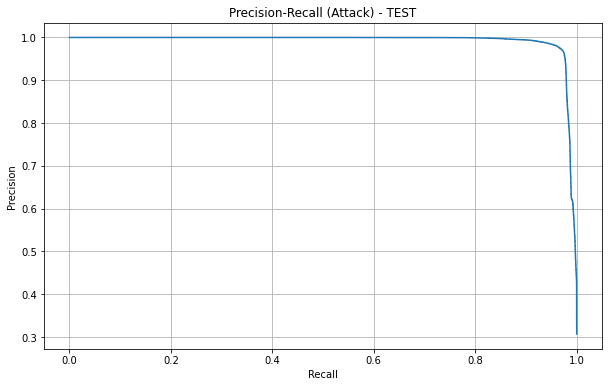

In [31]:
prec, rec, _ = precision_recall_curve(yt, pt)

plt.figure(figsize=(10, 6))
plt.plot(rec, prec)
plt.title("Precision-Recall (Attack) - TEST")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

INTERPRETABILIDAD

In [36]:
import os, json
import numpy as np
import pandas as pd

os.makedirs("exports", exist_ok=True)

ts_test_flow = df["Timestamp"].iloc[i_val:].reset_index(drop=True)

ends = np.array(test_ds.starts) + WINDOW_SIZE - 1
ts_test_win = ts_test_flow.iloc[ends].reset_index(drop=True)

p_attack = pt.astype(float)      # pt = prob Attack
y_true = yt.astype(int)
y_pred = (p_attack >= 0.5).astype(int)

out = pd.DataFrame({
    "pipeline": "p3_pca_transformer",
    "timestamp": ts_test_win,
    "y_true": y_true,
    "y_pred": y_pred,
    "p_attack": p_attack,
    "window_start": np.array(test_ds.starts, dtype=int),
    "window_end": ends.astype(int),
    "window_size": int(WINDOW_SIZE),
    "stride": int(STRIDE),
})

out.to_parquet("exports/p3_test_preds.parquet", index=False)
print("Guardado:", "exports/p3_test_preds.parquet", "| shape:", out.shape)

meta = {
    "pipeline": "p3_pca_transformer",
    "task": "binary",
    "split": "temporal",
    "train_frac": 0.70,
    "val_frac": 0.15,
    "test_frac": 0.15,
    "pca_components": int(X_train_pca.shape[1]),
    "window_size": int(WINDOW_SIZE),
    "stride": int(STRIDE),
}
with open("exports/p3_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, default=str)
print("Guardado:", "exports/p3_meta.json")


Guardado: exports/p3_test_preds.parquet | shape: (84913, 9)
Guardado: exports/p3_meta.json


PERMUTATION IMPORTANCE


In [12]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
import torch
from torch.utils.data import DataLoader, Dataset

# ==============================
# Permutation Importance (P3)
# ==============================
# Requiere que existan:
# - X_test_pca (n_flows_test, D)
# - y_test     (n_flows_test,)
# - WINDOW_SIZE, STRIDE
# - model (ya con best_state cargado)
# Métrica: AP / PR-AUC (Attack) en TEST

os.makedirs("exports", exist_ok=True)

def make_window_indices(n, window_size, stride):
    return list(range(0, n - window_size + 1, stride))

class SeqWindowBinaryDataset_Array(Dataset):
    def __init__(self, X_pca, y_bin, window_size, stride):
        self.X = torch.tensor(X_pca, dtype=torch.float32)
        self.y = np.asarray(y_bin, dtype=np.int64)
        self.ws = window_size
        self.starts = make_window_indices(len(self.y), window_size, stride)

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, k):
        i = self.starts[k]
        x_win = self.X[i:i+self.ws]              # (T, D)
        y_win = int(self.y[i+self.ws-1])         # etiqueta del último flujo
        return x_win, y_win

@torch.no_grad()
def predict_p_attack_from_arrays(X_pca, y_flow, batch_size=256):
    ds = SeqWindowBinaryDataset_Array(X_pca, y_flow, WINDOW_SIZE, STRIDE)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False, drop_last=False)

    model.eval()
    ys, ps = [], []

    for xb, yb in dl:
        xb = xb.to(device)
        logits = model(xb)
        prob = torch.sigmoid(logits).cpu().numpy()
        ys.append(yb.numpy())
        ps.append(prob)

    y_true_w = np.concatenate(ys)
    p_attack_w = np.concatenate(ps)
    return y_true_w, p_attack_w

# --- Baseline AP ---
y_base, p_base = predict_p_attack_from_arrays(X_test_pca, y_test, batch_size=BATCH_SIZE)
base_ap = average_precision_score(y_base, p_base)
print("Baseline TEST AP (Attack):", base_ap)

# --- Permutation loop ---
D = X_test_pca.shape[1]
n_repeats = 1          # pon 3 si quieres más estable (más lento)
max_features = D       # o 20 para prueba rápida

rng = np.random.default_rng(42)
importances = np.zeros(D, dtype=float)

for j in range(min(D, max_features)):
    drops = []
    for r in range(n_repeats):
        Xp = X_test_pca.copy()
        col = Xp[:, j].copy()
        rng.shuffle(col)
        Xp[:, j] = col

        y_perm, p_perm = predict_p_attack_from_arrays(Xp, y_test, batch_size=BATCH_SIZE)
        ap_perm = average_precision_score(y_perm, p_perm)
        drops.append(base_ap - ap_perm)

    importances[j] = float(np.mean(drops))
    if (j + 1) % 5 == 0 or j == 0:
        print(f"Feature PC{j}: ΔAP={importances[j]:.6f}")

pi_df = pd.DataFrame({
    "pc": [f"PC{i}" for i in range(D)],
    "ap_drop": importances
}).sort_values("ap_drop", ascending=False)

print("\nTop 15 PCs por importancia (caída AP):")
display(pi_df.head(15))

pi_df.to_parquet("exports/p3_permutation_importance.parquet", index=False)
print("Guardado -> exports/p3_permutation_importance.parquet")


Baseline TEST AP (Attack): 0.9937102142693292
Feature PC0: ΔAP=0.048427
Feature PC4: ΔAP=0.033853
Feature PC9: ΔAP=0.000061
Feature PC14: ΔAP=0.005898
Feature PC19: ΔAP=0.000470
Feature PC24: ΔAP=0.000815

Top 15 PCs por importancia (caída AP):


,pc,ap_drop
3,PC3,0.077845
0,PC0,0.048427
4,PC4,0.033853
23,PC23,0.013547
5,PC5,0.007758
7,PC7,0.007673
25,PC25,0.006571
14,PC14,0.005898
2,PC2,0.005776
22,PC22,0.005044


Guardado -> exports/p3_permutation_importance.parquet


SOLUCIONANDO


In [40]:
import numpy as np
import pandas as pd

# df ya ordenado por Timestamp y con columna Attack (0/1)
# y_test_flow: array (n_test_flows,) con Attack de test a nivel de flujo
y_test_flow = df["Attack"].iloc[i_val:].to_numpy()

# Carga preds de P3 o P2 exportadas
preds = pd.read_parquet("exports/p3_test_preds.parquet")   # o p2_test_preds.parquet
# Nos quedamos con los FP más extremos
fp_ext = preds[(preds["y_true"]==0) & (preds["y_pred"]==1)].sort_values("p_attack", ascending=False).head(200)

# Para P2/P3 tienes window_start y window_end en el export:
# window_start es relativo al split de test (0..)
# window_end = window_start + WINDOW_SIZE - 1

def window_attack_stats(row):
    s = int(row["window_start"])
    e = int(row["window_end"])
    w = y_test_flow[s:e+1]
    return pd.Series({
        "attack_count_in_window": int(w.sum()),
        "attack_ratio_in_window": float(w.mean()),
        "last_label": int(w[-1]),
        "any_attack": int(w.sum() > 0)
    })

fp_ext_stats = fp_ext.join(fp_ext.apply(window_attack_stats, axis=1))
fp_ext_stats[["p_attack","attack_count_in_window","attack_ratio_in_window","any_attack"]].head(20)
print("FP extremos con any_attack=1:", (fp_ext_stats["any_attack"]==1).mean())


FP extremos con any_attack=1: 0.025


In [41]:
# Ejemplo: inspeccionar vecinos temporales de un FP extremo
row = fp_ext.iloc[0]
t = row["timestamp"]

# si tienes df_test_flow con Timestamp a nivel de flujo:
df_test_flow = df.iloc[i_val:].reset_index(drop=True)  # mismo orden que y_test_flow

# saca +- N flujos alrededor del window_end de ese FP
end = int(row["window_end"])
N = 50
snippet = df_test_flow.iloc[max(0,end-N): end+N+1][["Timestamp","Attack","Label"]]
snippet.head(), snippet.tail()
print(snippet["Attack"].value_counts(dropna=False))


Attack
0    101
Name: count, dtype: int64


In [42]:
# Columnas numéricas
import numpy as np
X_test_df = df_test_flow.select_dtypes(include=[np.number])

# Índices de flujos para el FP: puedes usar window_end (último flujo) o todo el rango
idx_fp_flow = end  # último flujo
fp_vals = X_test_df.iloc[idx_fp_flow]

# Compara con distribución benignas en test
benign_idx = np.where(y_test_flow==0)[0]
ref = X_test_df.iloc[np.random.choice(benign_idx, size=5000, replace=False)]

z = (fp_vals - ref.mean()) / (ref.std() + 1e-9)
z.sort_values(key=np.abs, ascending=False).head(20)


FIN Flag Count            8.851520
Fwd Packets/s             2.901496
Flow Packets/s            2.821947
Protocol                 -0.906213
min_seg_size_forward     -0.781127
Down/Up Ratio            -0.780810
Bwd Packet Length Min    -0.740731
ACK Flag Count           -0.689080
Min Packet Length        -0.632545
Average Packet Size      -0.582602
Packet Length Mean       -0.562396
Avg Bwd Segment Size     -0.559730
Bwd Packet Length Mean   -0.559730
PSH Flag Count           -0.525458
Destination Port         -0.511320
Bwd Packet Length Max    -0.470888
URG Flag Count           -0.462114
Packet Length Std        -0.442498
Init_Win_bytes_forward   -0.426871
Max Packet Length        -0.425366
dtype: float64

In [43]:
print("FP extremos con any_attack=1:", (fp_ext_stats["any_attack"]==1).mean())
print(fp_ext_stats[["p_attack","attack_count_in_window","attack_ratio_in_window"]].describe())


FP extremos con any_attack=1: 0.025
         p_attack  attack_count_in_window  attack_ratio_in_window
count  200.000000              200.000000              200.000000
mean     0.999197                0.330000                0.016500
std      0.000340                2.323379                0.116169
min      0.998567                0.000000                0.000000
25%      0.998896                0.000000                0.000000
50%      0.999254                0.000000                0.000000
75%      0.999463                0.000000                0.000000
max      0.999897               19.000000                0.950000
